### exercise 5: dimension reduction 

### task 1: principal component regression

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt
from operator import itemgetter

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

# print numpy arrays with precision 4
np.set_printoptions(precision=4)

In [2]:
hitters = pd.read_csv(r'C:\Users\Chijun Zhang\Documents\jupyter\machine learning exercise\datasets\Hitters.csv', index_col=0).dropna()
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])
hitters = hitters.drop(['League', 'Division', 'NewLeague'], axis=1)
hitters = pd.concat([hitters, dummies[['League_N', 'Division_W', 'NewLeague_N']]],axis=1)
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


In [3]:
X = hitters.drop('Salary', axis = 1).values
y = hitters.Salary.values

In [4]:
pca = PCA()

X_pcs = pca.fit_transform(scale(X))
print('The principal comoponent matrix has shape (num_samples, num_pcs)=', X_pcs.shape, '\n')
print('The first two PCs have the following first 5 scores: \n \n', X_pcs[0:5,0:2], '\n')

loadings = pca.components_
print('The loadings matrix has shape (num_pcs, num_features) =', loadings.shape, '\n')
print('The 19 loadings for the first two principal components are:\n \n', loadings[:,0:2])

The principal comoponent matrix has shape (num_samples, num_pcs)= (263, 19) 

The first two PCs have the following first 5 scores: 
 
 [[-0.0096  1.8705]
 [ 0.4114 -2.4294]
 [ 3.4668  0.8259]
 [-2.5583 -0.231 ]
 [ 1.0277 -1.5735]] 

The loadings matrix has shape (num_pcs, num_features) = (19, 19) 

The 19 loadings for the first two principal components are:
 
 [[ 0.1983  0.1959]
 [-0.3838 -0.3773]
 [ 0.0886  0.074 ]
 [ 0.032   0.018 ]
 [ 0.0281 -0.0047]
 [-0.0706 -0.0822]
 [ 0.107   0.13  ]
 [ 0.2698  0.3887]
 [-0.0122 -0.0616]
 [ 0.1456  0.1305]
 [ 0.0973  0.0144]
 [ 0.1031  0.121 ]
 [-0.0399  0.0036]
 [ 0.3062  0.2106]
 [ 0.5324 -0.0234]
 [-0.5103  0.7202]
 [ 0.1393 -0.1674]
 [-0.1068  0.0436]
 [ 0.0538 -0.0978]]


In [5]:
scores = []
percent_variance = []

num_components = list(np.arange(1,X.shape[1]+1))
num_samples = X.shape[0]

sc=cross_validate(LinearRegression(), np.ones((num_samples,1)), y,scoring = 'neg_mean_squared_error',cv=10)
scores.append(np.mean(sc['test_score']) * -1)

for n in num_components:
    pca = PCA(n_components=n)
    
    model = Pipeline([('scaler', StandardScaler()), ('pca', pca), ('linear_regression', LinearRegression())])
    
    model.fit(X,y)
    sc=cross_validate(model, X, y, scoring='neg_mean_squared_error', cv=10)
    scores.append(np.mean(sc['test_score']) * -1)
    percent_variance.append(np.sum(pca.explained_variance_ratio_))

print('Percent Variance Explained by number of components:\n\n', pd.Series(percent_variance, index=range(1,20)))

Percent Variance Explained by number of components:

 1     0.383142
2     0.601553
3     0.708417
4     0.790342
5     0.842903
6     0.886348
7     0.922629
8     0.949630
9     0.962827
10    0.972554
11    0.979778
12    0.986487
13    0.991518
14    0.994730
15    0.997466
16    0.998940
17    0.999682
18    0.999938
19    1.000000
dtype: float64


(-1.0, 19.95)

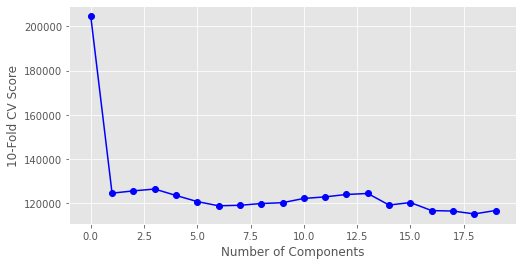

In [6]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(scores, marker='o', color='b')
ax.set_xlabel('Number of Components')
ax.set_ylabel('10-Fold CV Score')
ax.set_xlim(xmin=-1)

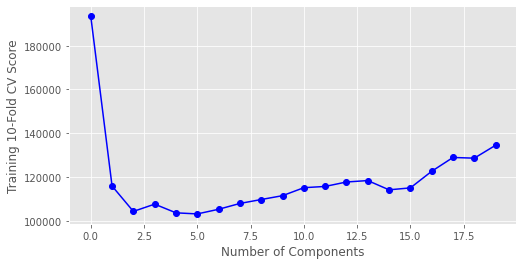

In [7]:
np.random.seed(2)

train = np.random.choice([True, False], size=len(hitters))

X_train = X[train]
y_train = y[train]
X_test = X[~train]
y_test = y[~train]

num_samples = X_train.shape[0]

scores = []

num_components = list(np.arange(1,X_train.shape[1]+1))
num_samples = X_train.shape[0]

sc=cross_validate(LinearRegression(), np.ones((num_samples,1)), y_train, cv=10, scoring = 'neg_mean_squared_error')
scores.append(np.mean(sc['test_score']) * -1)

for n in num_components:

    pca = PCA(n_components=n)
    
    model = Pipeline([('scaler', StandardScaler()), ('pca', pca), ('linear_regression', LinearRegression())])
    
    model.fit(X_train,y_train)
    sc=cross_validate(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
    scores.append(np.mean(sc['test_score']) * -1)


fig, ax = plt.subplots(figsize=(8,4))
ax.plot(scores, marker='o', color='b');
ax.set_xlabel('Number of Components');
ax.set_ylabel('Training 10-Fold CV Score');
ax.set_xlim(xmin=-1);

In [8]:
pca = PCA(n_components=5)

model = Pipeline([('scaler', StandardScaler()), ('pca', pca), ('linear_regression', LinearRegression())])
    
model.fit(X_train,y_train) 

y_predict=model.predict(X_test)

MSE = np.mean((y_predict-y_test)**2)
print(MSE)

139862.01933304142
